In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.model_selection import cross_val_score,KFold
from sklearn.metrics import accuracy_score,confusion_matrix

In [ ]:
from google.colab import drive

In [4]:
milk_df = pd.read_csv("/content/drive/MyDrive/data/milk_quality.csv")
milk_df.head()

,pH,Temprature,Taste,Odor,Fat,Turbidity,Colour,Grade
0,6.6,35,1,0,1,0,254,high
1,6.6,36,0,1,0,1,253,high
2,8.5,70,1,1,1,1,246,low
3,9.5,34,1,1,0,1,255,low
4,6.6,37,0,0,0,0,255,medium


In [ ]:
milk_df.isnull().sum()

pH            0
Temprature    0
Taste         0
Odor          0
Fat           0
Turbidity     0
Colour        0
Grade         0
dtype: int64

In [ ]:
milk_df.shape

(1059, 8)

In [5]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
grade = le.fit_transform(milk_df["Grade"])   
milk_df["Grade"] =grade
milk_df.head()

,pH,Temprature,Taste,Odor,Fat,Turbidity,Colour,Grade
0,6.6,35,1,0,1,0,254,0
1,6.6,36,0,1,0,1,253,0
2,8.5,70,1,1,1,1,246,1
3,9.5,34,1,1,0,1,255,1
4,6.6,37,0,0,0,0,255,2


**0 - High\
1 - Low\
2 - Medium**

In [8]:
milk_df2 = milk_df.copy(deep=True)
#Getting Outliers Percentage for all columns 
for k, v in milk_df2.items(): 
    q1 = v.quantile(0.25)
    q3 = v.quantile(0.75)
    iqr = q3 - q1 #Inter-Quartile Range (IQR) Method
    v_col = v[(v <= q1 - 1.5 * iqr) | (v >= q3 + 1.5 * iqr)]
    perc = np.shape(v_col)[0] * 100.0 / np.shape(milk_df2)[0]
    print(f"{k} Outliers = {round(perc, 2)}")

pH Outliers = 35.79
Temprature Outliers = 9.73
Taste Outliers = 0.0
Odor Outliers = 0.0
Fat  Outliers = 0.0
Turbidity Outliers = 0.0
Colour Outliers = 3.02
Grade Outliers = 0.0


In [9]:
def remove_outlier(df_in, col):
  for i in col:
    q1 = df_in[i].quantile(0.25)
    q3 = df_in[i].quantile(0.75)
    iqr = q3-q1 #Interquartile range
    fence_low  = q1-1.5*iqr
    fence_high = q3+1.5*iqr
    df_out = df_in.loc[(df_in[i] > fence_low) & (df_in[i] < fence_high)]
  return df_out
milk_df3 = remove_outlier(milk_df2, ['pH'])

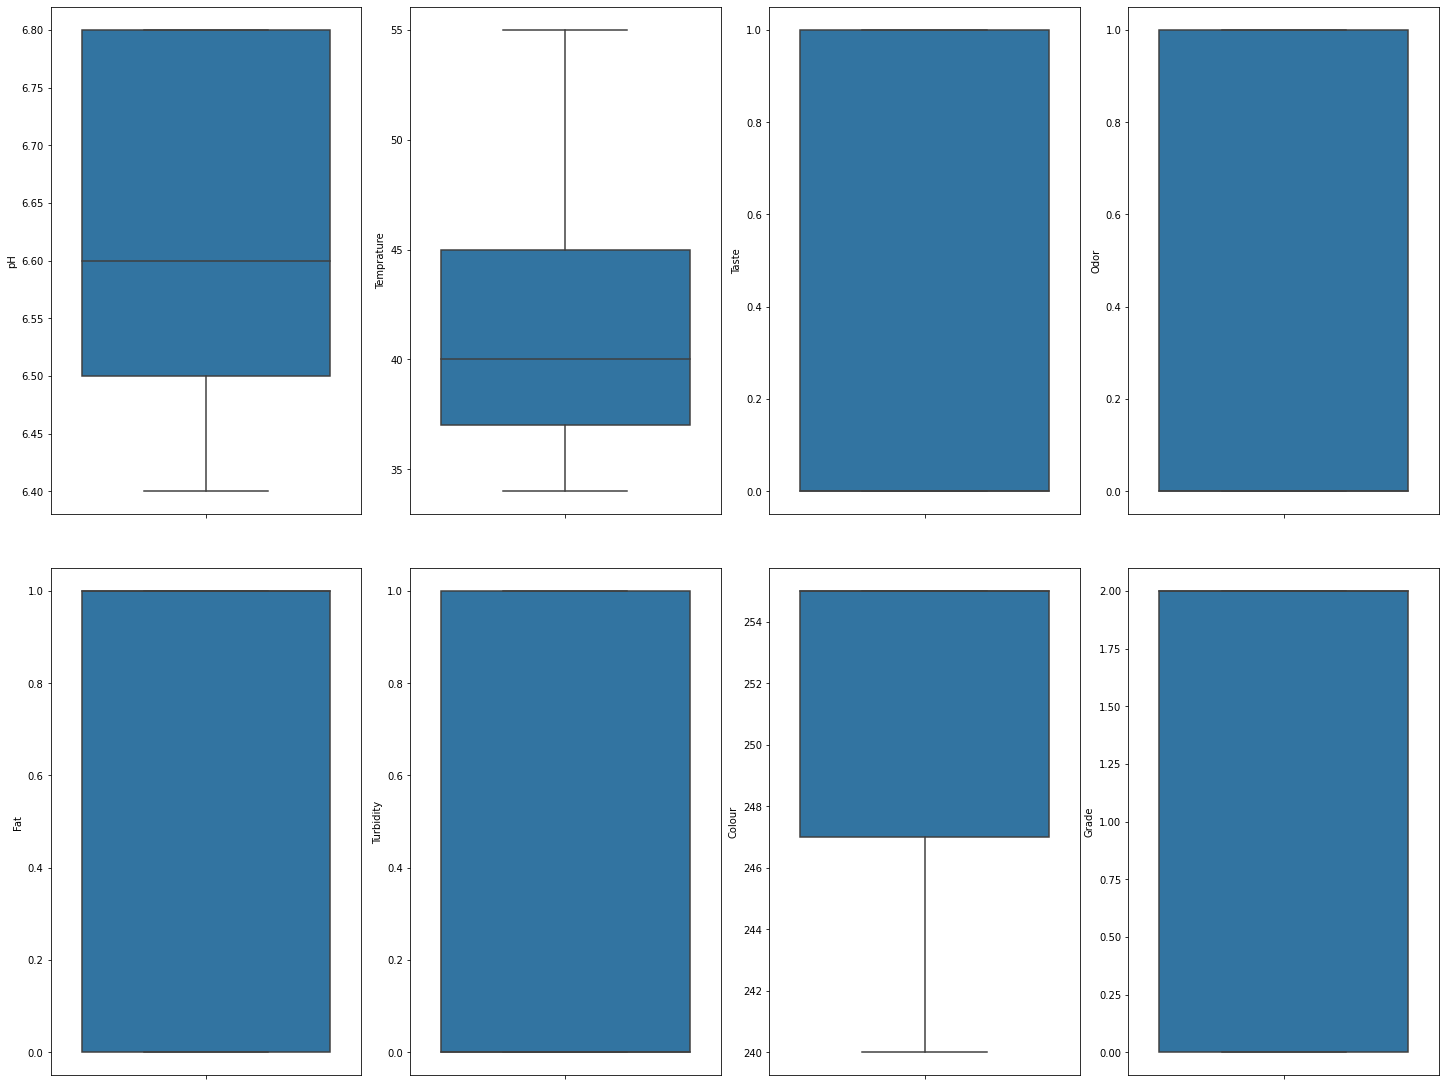

In [10]:
#Visualization of the Outliers for all columns using Boxplot
fig, axs = plt.subplots(ncols=4, nrows=2, figsize=(20,15))
index = 0
axs = axs.flatten()
for k, v in milk_df3.items(): 
    sns.boxplot(y=k, data=milk_df3, ax=axs[index]) 
    index += 1
plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=5.0)

In [11]:
ct = make_column_transformer(
    (MinMaxScaler(), ['pH', 'Temprature', 'Colour']), #Normalize the Data
    )

In [12]:
X = milk_df3.drop('Grade', axis=1)
Y = milk_df3['Grade']

In [13]:
#Split data into Training and Test
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=53)

In [14]:
# Transform training data 
ct.fit(X_train)
#Transform training and test data with normalization 
#(MinMaxScaler)
X_train_normal = ct.transform(X_train)
X_test_normal = ct.transform(X_test)

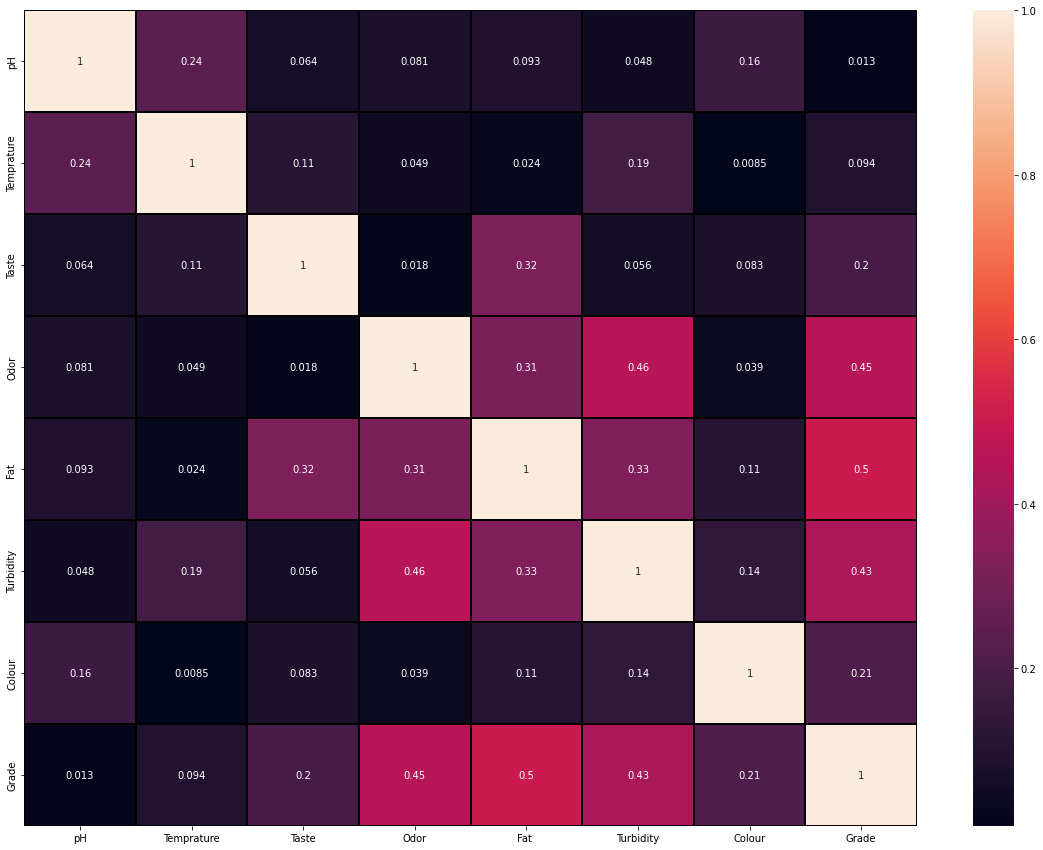

In [15]:
# When we say data is correlated that means the data is related to each other. When a feature moves in a
# certain direction a label also tends to move in that same direction
plt.figure(figsize=(20,15))
sns.heatmap(milk_df.corr().abs(), annot=True, linecolor='black', linewidths=1)

# **Random Forest Model**

In [30]:
from sklearn.ensemble import RandomForestClassifier
random_forest = RandomForestClassifier(n_estimators = 20)

In [ ]:
random_forest.fit(X_train_normal, Y_train) #Fitting the Training Data into the model
y_random_predict = random_forest.predict(X_test_normal) #Predicting the Test data
accuracy_random = accuracy_score(Y_test, y_random_predict) #Finding out the Test accuracy
print(f"Accuracy of the model(Random Forest) is : {round(accuracy_random*100, 2)} %")

Accuracy of the model(Random Forest) is : 87.5 %


In [ ]:
confusion_matrix(Y_test, y_random_predict) #Confusion Matrix

array([[47,  0, 12],
       [ 0, 14,  0],
       [ 5,  0, 58]])

In [ ]:
#Using K-Fold Cross Validation for Prediction Using Random Forest
kfold = KFold(n_splits=5, random_state=72, shuffle=True) #K-Fold Cross Validation
scores = cross_val_score(random_forest, X, Y, cv=kfold)
print('Cross validation accuracies :',scores*100) #Accuracy for each split during K-Fold Cross Validation
print(f"Overall Accuracy by using KFold method is {round(scores.mean()*100, 2)} % (Random Forest)") #Mean of all the accuracy scores

Cross validation accuracies : [100.          98.52941176 100.          99.26470588 100.        ]
Overall Accuracy by using KFold method is 99.56 % (Random Forest)


# **Logistic Regression Model**

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
lr = LogisticRegression(max_iter=10000) #Logistic Regression Model
lr.fit(X_train_normal,Y_train) #Fitting the Training Data into the model
test_prediction = lr.predict(X_test_normal) #Predicting the Test data 
accuracy_lr = accuracy_score(Y_test, test_prediction) #Finding out the Test accuracy
print(f"Accuracy of the model(Logistic Regression) is : {round(accuracy_lr*100, 2)} %")

Accuracy of the model(Logistic Regression) is : 64.71 %


In [ ]:
confusion_matrix(Y_test, test_prediction) #Confusion Matrix

array([[23,  0, 36],
       [ 2, 10,  2],
       [ 8,  0, 55]])

In [ ]:
scores_lr = cross_val_score(lr, X, Y, cv=kfold)
print('Cross validation accuracies :',scores_lr*100) #Accuracy for each split during K-Fold Cross Validation
print(f"Overall Accuracy by using KFold method is {round(scores_lr.mean()*100, 2)} % (Logistic Regression)") #Mean of all the accuracy scores

Cross validation accuracies : [98.52941176 93.38235294 95.58823529 88.23529412 97.05882353]
Overall Accuracy by using KFold method is 94.56 % (Logistic Regression)


# **K-Nearest Neighbours (KNN) Model**

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:
from math import sqrt
sqrt(len(Y_test)) #Finding out value of k

11.661903789690601

In [ ]:
knn = KNeighborsClassifier(n_neighbors=11, p=2, metric='euclidean') #KNN Model
knn.fit(X_train_normal, Y_train) #Fitting the Training Data into the model
y_predict = knn.predict(X_test_normal) #Predicting the Test data
accuracy_knn = accuracy_score(Y_test, y_predict) #Finding out the Test accuracy
print(f"Accuracy of the model(KNN) is : {round(accuracy_knn*100, 2)} %")

Accuracy of the model(KNN) is : 80.88 %


In [ ]:
confusion_matrix(Y_test, y_predict) #Confusion Matrix

array([[40,  0, 19],
       [ 0, 12,  2],
       [ 4,  1, 58]])

In [ ]:
scores_knn = cross_val_score(knn, X, Y, cv=kfold)
print('Cross validation accuracies :',scores_knn*100) #Accuracy for each split during K-Fold Cross Validation
print(f"Overall Accuracy by using KFold method is {round(scores_knn.mean()*100, 2)} % (KNN)") #Mean of all the accuracy scores

Cross validation accuracies : [98.52941176 97.05882353 99.26470588 94.11764706 96.32352941]
Overall Accuracy by using KFold method is 97.06 % (KNN)


# **SVM - RBF**

In [ ]:
from sklearn.svm import SVC

In [ ]:
svm_rbf = SVC(kernel = 'rbf') #SVM - RBF Model
svm_rbf.fit(X_train_normal, Y_train)
Y_predict_rbf = svm_rbf.predict(X_test_normal) #Predicting the Test data
accuracy_svm_rbf = accuracy_score(Y_test, Y_predict_rbf) #Finding out the Test accuracy
print(f"Accuracy of the model(SVM - RBF) is : {round(accuracy_svm_rbf*100, 2)} %")

Accuracy of the model(SVM - RBF) is : 77.94 %


In [ ]:
confusion_matrix(Y_test, Y_predict_rbf) #Confusion Matrix

array([[44,  0, 15],
       [ 0, 14,  0],
       [15,  0, 48]])

In [ ]:
scores_svm = cross_val_score(svm_rbf, X, Y, cv=kfold)
print('Cross validation accuracies :',scores_svm*100) #Accuracy for each split during K-Fold Cross Validation
print(f"Overall Accuracy by using KFold method is {round(scores_svm.mean()*100, 2)} % (SVM - RBF)") #Mean of all the accuracy scores

Cross validation accuracies : [61.02941176 57.35294118 55.88235294 51.47058824 49.26470588]
Overall Accuracy by using KFold method is 55.0 % (SVM - RBF)


# After going through all the models accuracy, we can find that Random Forest model is the best fit model for the prediction of the given problem statement (milk_quality) in both the normal and cross-validation (k-fold) models.